In [26]:
import os,gc
import pandas as pd
import numpy as np
import copy
from mlens.visualization import corrmat  # https://zhuanlan.zhihu.com/p/32949396
import matplotlib.pyplot as plt

user_folder = os.path.expanduser('~')
data_folder = os.path.join(user_folder, 'E:/git/database/Toxic_Comment/blends')
files = os.listdir(data_folder)
files

['lgb_submission.csv',
 'Logistic_regression_with_words_and_char_n-grams.csv',
 'Minimal_LSTM_NB-SVM_baseline_ensemble.csv',
 'one_more_blend.csv',
 'Pooled_GRU_Fasttext.csv',
 'tidy_glm.csv',
 'toxic_avenger.csv',
 'who09829_gru.csv']

In [67]:
gru = pd.read_csv(os.path.join(data_folder, 'Pooled_GRU_Fasttext.csv')) # PL score 0.9829
lstm_nb_svm = pd.read_csv(os.path.join(data_folder, 'Minimal_LSTM_NB-SVM_baseline_ensemble.csv' )) # 0.9811
lr = pd.read_csv(os.path.join(data_folder, "Logistic_regression_with_words_and_char_n-grams.csv")) # 0.9788
lgb = pd.read_csv(os.path.join(data_folder, "lgb_submission.csv")) # 0.9785
blend_p = pd.read_csv(os.path.join(data_folder, 'one_more_blend.csv')) # 0.9850

# https://www.kaggle.com/kailex/tidy-xgboost-glmnet-text2vec-lsa/code
glm = pd.read_csv(os.path.join(data_folder, 'tidy_glm.csv')) # 0.9788

# https://www.kaggle.com/eashish/bidirectional-lstm-with-convolution/output

ave = pd.read_csv(os.path.join(data_folder, 'toxic_avenger.csv')) # 0.9823


weights = pd.Series([0.9829, 0.9811, 0.9788, 0.9785, 0.9788])


### scaling

In [68]:
# Bojan suggests scaling with min-max to make sure that all the submissions have
# orderings that can be compared. Since our metric is AUC, this is okay and may
# improve performance.

from sklearn.preprocessing import minmax_scale
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
for label in labels:
    print('Scaling {}... Please stand by.'.format(label))
    lgb[label] = minmax_scale(lgb[label])
    gru[label] = minmax_scale(gru[label])
    lr[label] = minmax_scale(lr[label])
    lstm_nb_svm[label] = minmax_scale(lstm_nb_svm[label])
    #blend_p[label] = minmax_scale(blend_p[label])
    glm[label] = minmax_scale(glm[label])
    #ave[label] = minmax_scale(ave[label])


Scaling toxic... Please stand by.
Scaling severe_toxic... Please stand by.
Scaling obscene... Please stand by.
Scaling threat... Please stand by.
Scaling insult... Please stand by.
Scaling identity_hate... Please stand by.


In [70]:
class_data = {}
for label in labels:
    #matrix = [gru[label], lstm_nb_svm[label], lr[label], lgb[label], blend_p[label], ave[label], glm[label]]
    matrix = [gru[label], lstm_nb_svm[label], lr[label], lgb[label], glm[label]]
    matrix = pd.DataFrame(matrix)
    matrix = matrix.T
    matrix.columns = ['gru','lstm_nb_svm', 'lr', 'lgb', 'glm']
    class_data[label] = matrix
del matrix
gc.collect()

0

toxic


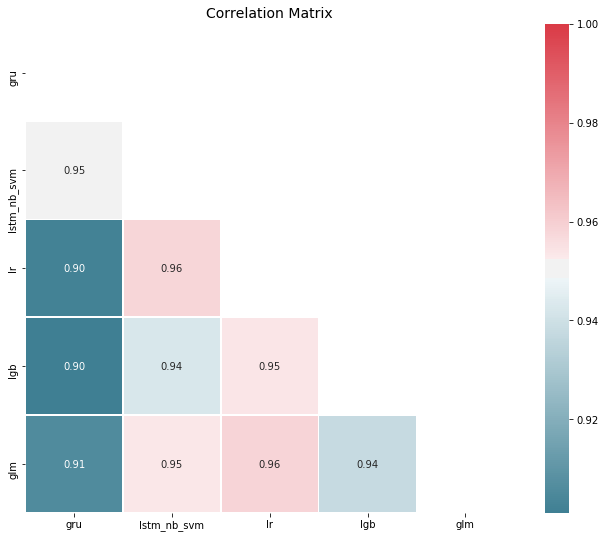

severe_toxic


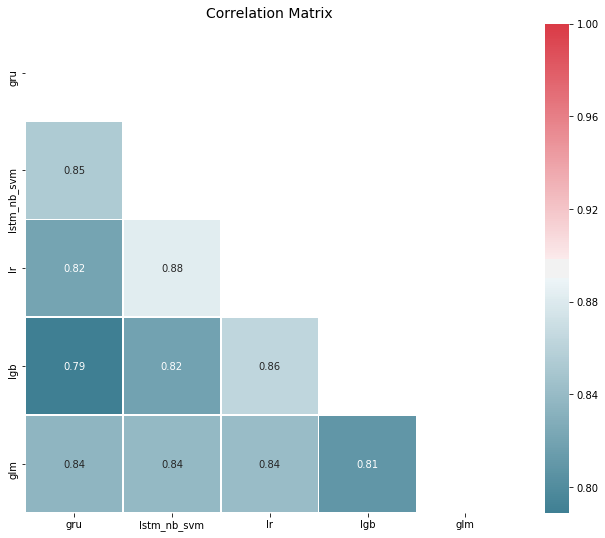

obscene


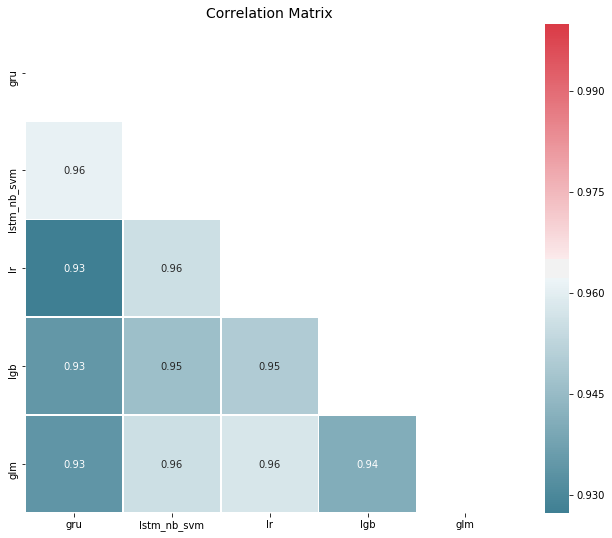

threat


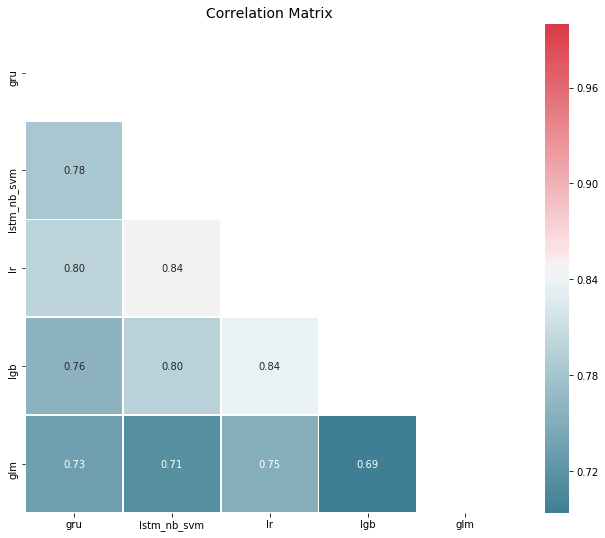

insult


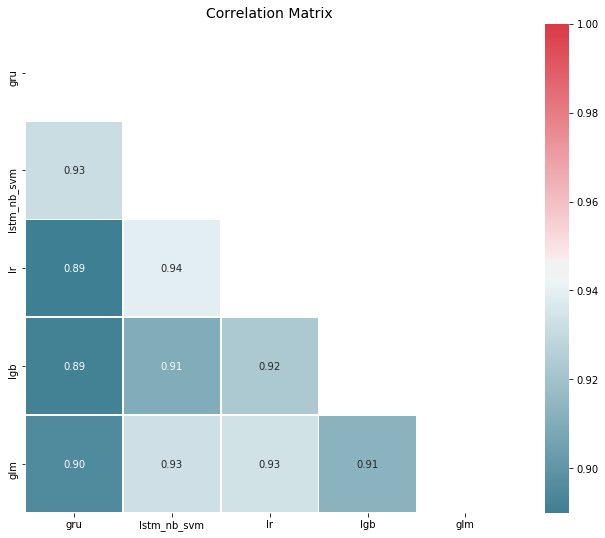

identity_hate


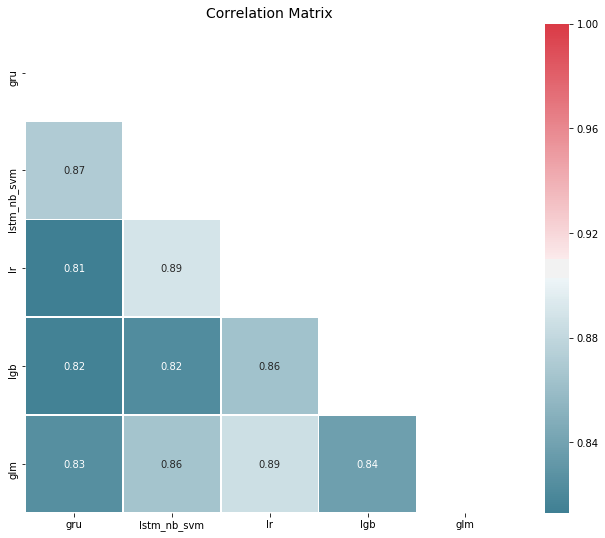

In [71]:
for label in labels:
    print(label)
    corrmat(class_data[label].corr(), inflate=False)
    plt.show()
    #print(np.corrcoef([gru[label], lstm_nb_svm[label], lr[label], lgb[label], blend_p[label]]))

In [72]:
submission = copy.deepcopy(gru)

In [74]:
# severe_toxic
for key in class_data.keys():
    weight_score = class_data[key]*weights.values/sum(weights.values)
    weight_score = weight_score.apply(sum, axis=1)
    submission[key] = weight_score

In [75]:
submission.head(3)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998864,0.300786,0.991128,0.037389,0.936183,0.285120
1,0000247867823ef7,0.004979,0.001300,0.002036,0.000206,0.003241,0.000920
2,00013b17ad220c46,0.008335,0.001402,0.004881,0.000296,0.003970,0.000934


In [76]:
submission.to_csv('myBlend_20180307_2.csv', index=False)

In [50]:
submission.head(1)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.992482,0.312776,0.978632,0.041128,0.946862,0.316
